Data: "MGE-derived interneurons integrated with 10X sequencing MOp data"

https://cellxgene.cziscience.com/collections/20a1dadf-a3a7-4783-b311-fcff3c457763

In [20]:
# Warning handling
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "8" # Defines the number of physical cores you have

In [72]:
## Import packages and data
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap

# Load the MGE-derived interneuron .h5ad file from https://cellxgene.cziscience.com/collections/20a1dadf-a3a7-4783-b311-fcff3c457763
adata = sc.read_h5ad("c2c0a633-136f-4c97-ab51-062ce97ad802.h5ad")

# Convert to DataFrame (genes as columns, cells as rows)
df = adata.to_df()

# Add metadata to the DataFrame
df.index = adata.obs.index  # Cell IDs
df.columns = adata.var.index  # Gene names
df_metadata = adata.obs.copy()  # Cell metadata
df_gene_info = adata.var.copy()  # Gene metadata

df.head()

,ENSMUSG00000026791,ENSMUSG00000029802,ENSMUSG00000107325,ENSMUSG00000057551,ENSMUSG00000056605,ENSMUSG00000035780,ENSMUSG00000045725,ENSMUSG00000027312,ENSMUSG00000030806,ENSMUSG00000060206,...,ENSMUSG00000038900,ENSMUSG00000032641,ENSMUSG00000085375,ENSMUSG00000110709,ENSMUSG00000073953,ENSMUSG00000115784,ENSMUSG00000075161,ENSMUSG00000034226,ENSMUSG00000059975,ENSMUSG00000043605
20180213_sample_5-0,19.0,36.0,0.0,65.0,0.0,0.0,0.0,192.0,91.0,90.0,...,23.0,102.0,0.0,0.0,0.0,0.0,0.0,43.0,0.0,0.0
20180215_sample_1-0,0.0,0.0,0.0,399.0,0.0,0.0,0.0,82.0,666.0,169.0,...,124.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20180220_sample_1-0,9.0,0.0,0.0,21.0,0.0,0.0,0.0,69.0,12.0,7.0,...,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20180225_sample_7-0,300.0,1.0,0.0,262.0,0.0,0.0,0.0,147.0,612.0,33.0,...,60.0,204.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20180306_sample_1-0,0.0,0.0,0.0,96.0,0.0,0.0,0.0,83.0,20.0,185.0,...,36.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


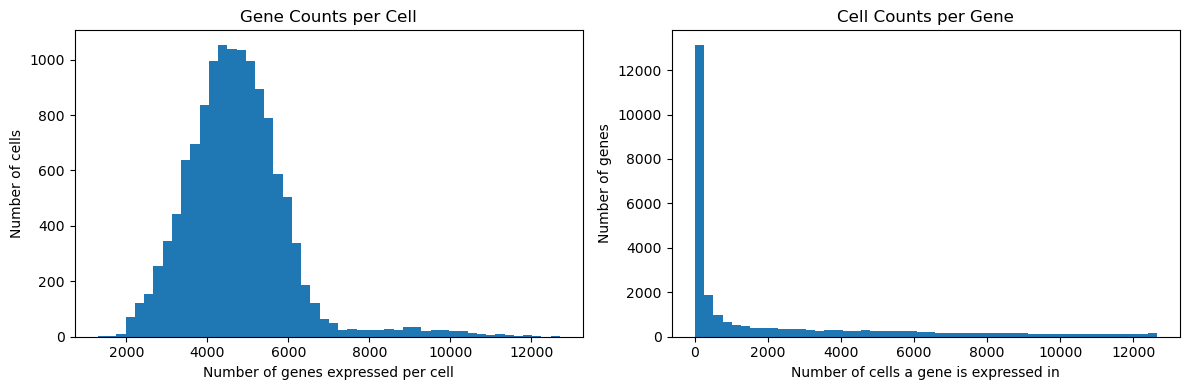

In [69]:
## Check the Distribution of Gene & Cell Counts
# Calculate number of expressed genes per cell
genes_per_cell = (df > 0).sum(axis=1)

# Calculate number of cells per gene
cells_per_gene = (df > 0).sum(axis=0)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot distribution of genes per cell
axes[0].hist(genes_per_cell, bins=50)
axes[0].set_xlabel("Number of genes expressed per cell")
axes[0].set_ylabel("Number of cells")
axes[0].set_title("Gene Counts per Cell")

# Plot distribution of cells per gene
axes[1].hist(cells_per_gene, bins=50)
axes[1].set_xlabel("Number of cells a gene is expressed in")
axes[1].set_ylabel("Number of genes")
axes[1].set_title("Cell Counts per Gene")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [25]:
## Preprocess gene expression data
# Normalize each cell to have 10,000 total counts
df_normalized = df.div(df.sum(axis=1), axis=0) * 1e4

# Log1p transformation (log(x + 1))
df_log = np.log1p(df_normalized)

# Show first rows
df_log.head()

,ENSMUSG00000026791,ENSMUSG00000029802,ENSMUSG00000107325,ENSMUSG00000057551,ENSMUSG00000056605,ENSMUSG00000035780,ENSMUSG00000045725,ENSMUSG00000027312,ENSMUSG00000030806,ENSMUSG00000060206,...,ENSMUSG00000038900,ENSMUSG00000032641,ENSMUSG00000085375,ENSMUSG00000110709,ENSMUSG00000073953,ENSMUSG00000115784,ENSMUSG00000075161,ENSMUSG00000034226,ENSMUSG00000059975,ENSMUSG00000043605
20180213_sample_5-0,0.215454,0.375378,0.0,0.600212,0.0,0.0,0.0,1.232430,0.766168,0.760270,...,0.255448,0.828857,0.0,0.0,0.0,0.0,0.0,0.434453,0.0,0.0
20180215_sample_1-0,0.000000,0.000000,0.0,0.957568,0.0,0.0,0.0,0.285120,1.302807,0.518771,...,0.404736,0.031680,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
20180220_sample_1-0,0.236346,0.000000,0.0,0.483719,0.0,0.0,0.0,1.113181,0.304158,0.188440,...,0.000000,0.571100,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
20180225_sample_7-0,0.836066,0.004348,0.0,0.761593,0.0,0.0,0.0,0.495040,1.299329,0.134356,...,0.232265,0.636018,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
20180306_sample_1-0,0.000000,0.000000,0.0,0.662795,0.0,0.0,0.0,0.594921,0.178879,1.033845,...,0.302012,0.330564,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


Explained variance by first 10 PCs: [0.05431883 0.02380748 0.0132913  0.01138443 0.01101794 0.01014169
 0.00802401 0.00595887 0.00521249 0.00394678]


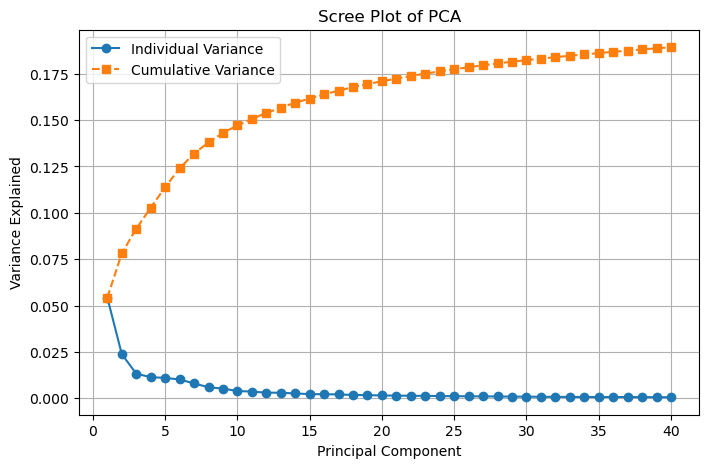

In [6]:
## Apply PCA to preprocessed data
# Run PCA
pca = PCA(n_components=40)
pca_result = pca.fit_transform(df_log)

# Convert PCA result to a DataFrame
df_pca = pd.DataFrame(pca_result, index=df_log.index)

# Check variance explained by top PCs
explained_variance = pca.explained_variance_ratio_
print("Explained variance by first 10 PCs:", explained_variance[:10])

# Compute cumulative variance
cumulative_variance = np.cumsum(explained_variance[:50])

# Plot Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, 41), explained_variance[:40], marker="o", linestyle="-", label="Individual Variance")
plt.plot(range(1, 41), cumulative_variance[:40], marker="s", linestyle="--", label="Cumulative Variance")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.title("Scree Plot of PCA")
plt.legend()
plt.grid()
plt.show()

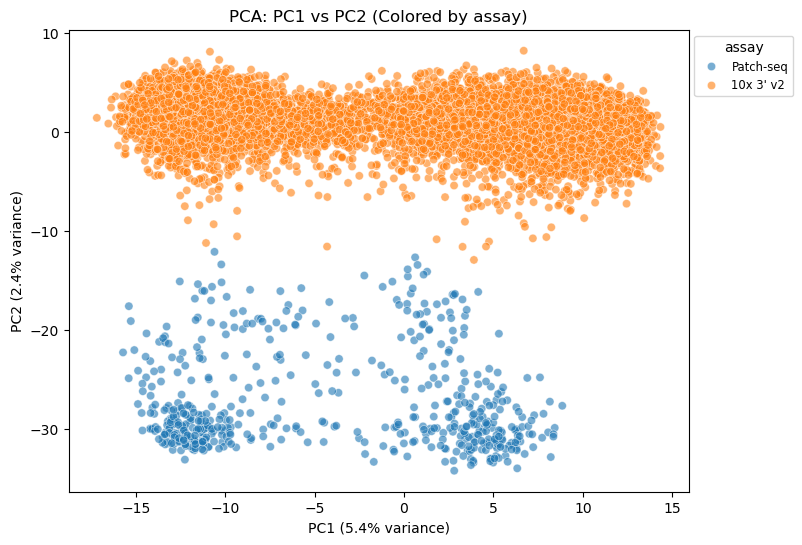

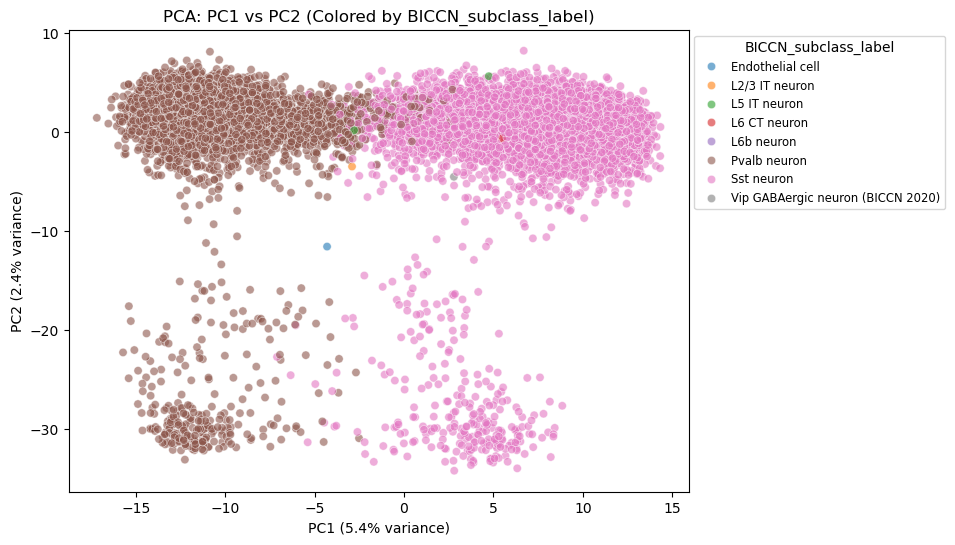

In [33]:
## Color PC1 vs. PC2 plots by assay type and BICCN subclass
features_to_plot = ['assay', 'BICCN_subclass_label']

for feature in features_to_plot:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df_pca[0], y=df_pca[1], hue=adata.obs.loc[df_pca.index, feature], 
                    palette="tab10", alpha=0.6)
    plt.xlabel(f"PC1 ({explained_variance[0]*100:.1f}% variance)")
    plt.ylabel(f"PC2 ({explained_variance[1]*100:.1f}% variance)")
    plt.title(f"PCA: PC1 vs PC2 (Colored by {feature})")
    plt.legend(title=feature, fontsize='small', bbox_to_anchor=(1, 1))
    plt.show()


Logistic Regression Accuracy: 1.00


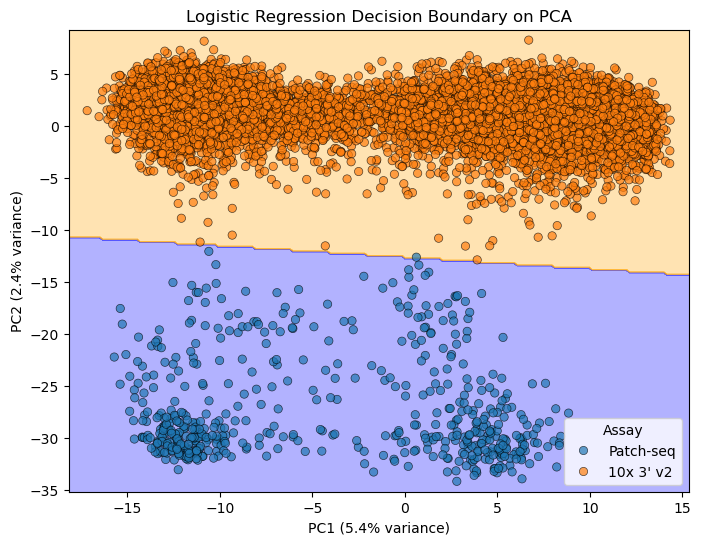

In [58]:
## Apply logistic regression boundary to PCA of assay type
# Extract PC1 and PC2
df_pca['PC1'] = df_pca[0]
df_pca['PC2'] = df_pca[1]

# Ensure 'assay' is categorical
df_pca['assay'] = adata.obs.loc[df_pca.index, 'assay']

# Convert 'assay' into numerical labels (binary classification)
# If 'assay' has more than two categories, you may need to adjust this
df_pca['assay_label'] = df_pca['assay'].astype('category').cat.codes

# Extract features and target
X = df_pca[['PC1', 'PC2']].values
y = df_pca['assay_label'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict and compute accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Logistic Regression Accuracy: {accuracy:.2f}')

# Plot decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# Predict probability for each point in meshgrid
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['blue', 'orange']))
sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'], hue=df_pca['assay'], edgecolor='k', alpha=0.7, palette="tab10")
plt.xlabel(f"PC1 ({explained_variance[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({explained_variance[1]*100:.1f}% variance)")
plt.title("Logistic Regression Decision Boundary on PCA")
plt.legend(title="Assay", loc='lower right')
plt.show()


Logistic Regression Accuracy: 0.99


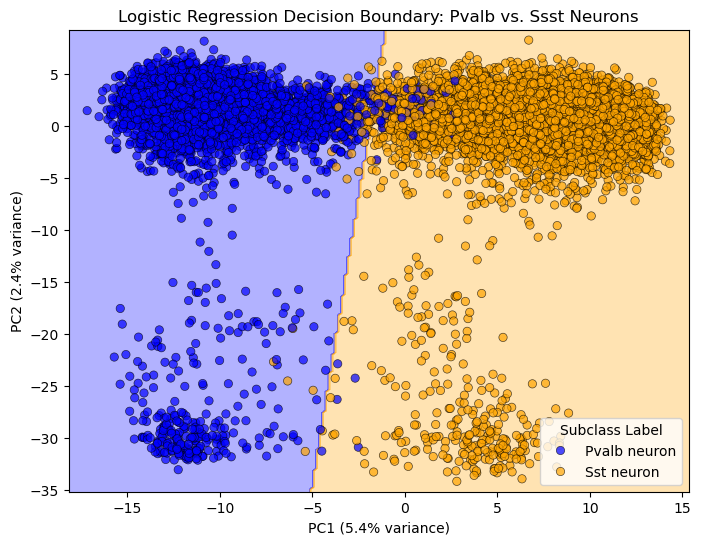

In [59]:
## Apply logistic regression boundary to PCA of BICCN subclass label type

df_pca['BICCN_subclass_label'] = adata.obs.loc[df_pca.index, 'BICCN_subclass_label']

# Filter only 'Pvalb neuron' and 'Ssst neuron' from BICCN_subclass_label
df_filtered = df_pca[df_pca['BICCN_subclass_label'].isin(['Pvalb neuron', 'Sst neuron'])].copy()
df_filtered['BICCN_subclass_label'] = df_filtered['BICCN_subclass_label'].cat.remove_unused_categories()

# Convert 'assay' into numerical labels (binary classification)
# If 'assay' has more than two categories, you may need to adjust this
df_filtered['subclass_label'] = df_filtered['BICCN_subclass_label'].astype('category').cat.codes

# Convert labels into binary values (0 and 1)
df_filtered['subclass_label'] = df_filtered['BICCN_subclass_label'].map({'Pvalb neuron': 0, 'Sst neuron': 1})

# Extract features and target
X = df_filtered[['PC1', 'PC2']].values
y = df_filtered['subclass_label'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict and compute accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Logistic Regression Accuracy: {accuracy:.2f}')

# Plot decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# Predict probability for each point in meshgrid
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
palette = {'Pvalb neuron': 'blue', 'Sst neuron': 'orange'}

# Plot decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['blue', 'orange']))
sns.scatterplot(x=df_filtered['PC1'], y=df_filtered['PC2'], hue=df_filtered['BICCN_subclass_label'], 
                edgecolor='k', alpha=0.7, palette=palette)
plt.xlabel(f"PC1 ({explained_variance[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({explained_variance[1]*100:.1f}% variance)")
plt.title("Logistic Regression Decision Boundary: Pvalb vs. Ssst Neurons")
plt.legend(title="Subclass Label", loc='lower right')
plt.show()

In [39]:
## Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(df_log)

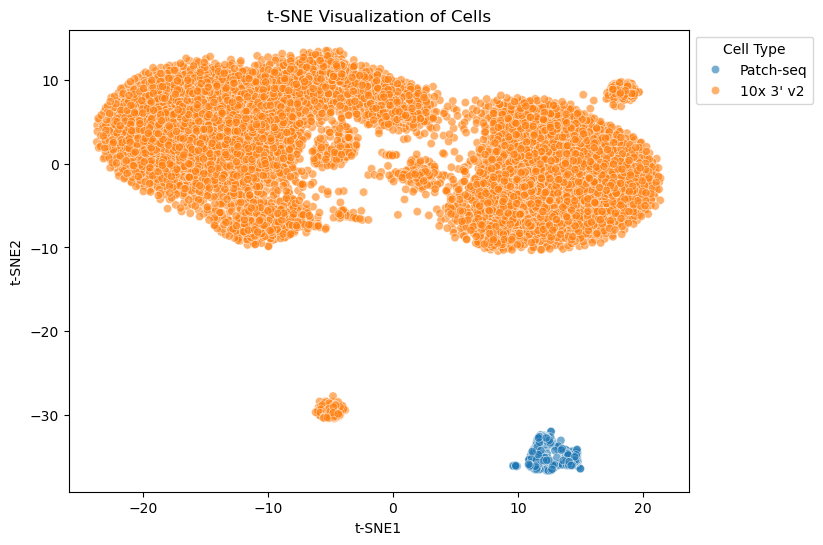

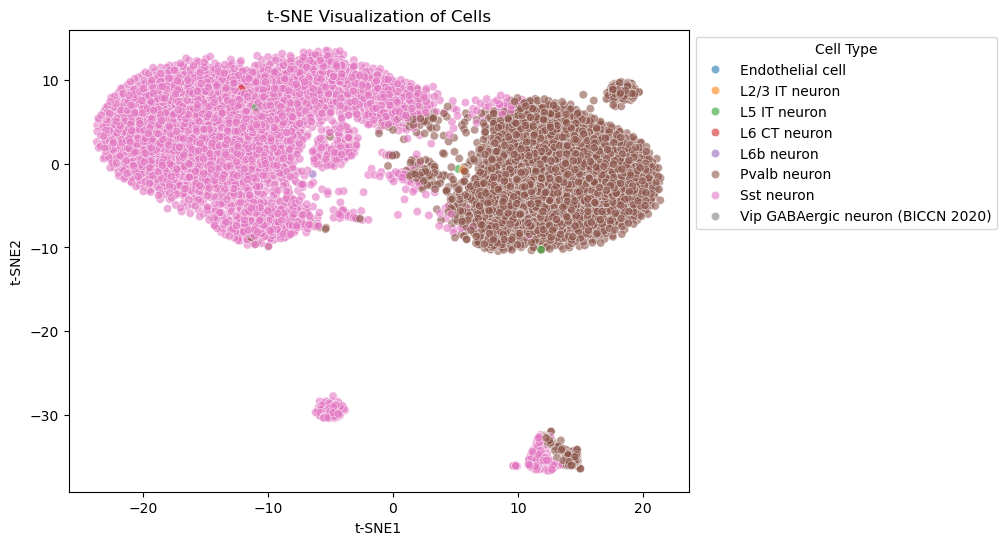

In [40]:
## Color t-SNE1 vs. t-SNE2 plots by assay type and BICCN subclass
# Convert to dataframe
df_log["tSNE1"] = tsne_results[:, 0]
df_log["tSNE2"] = tsne_results[:, 1]
df_log["cell_type"] = df_metadata["cell_type"]  # Add cell type labels

for feature in features_to_plot:
    # Plot t-SNE
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="tSNE1", y="tSNE2", hue=adata.obs.loc[df_pca.index, feature], data=df_log, alpha=0.6, palette="tab10")
    plt.xlabel("t-SNE1")
    plt.ylabel("t-SNE2")
    plt.title("t-SNE Visualization of Cells")
    plt.legend(title="Cell Type", bbox_to_anchor=(1, 1))
    plt.show()

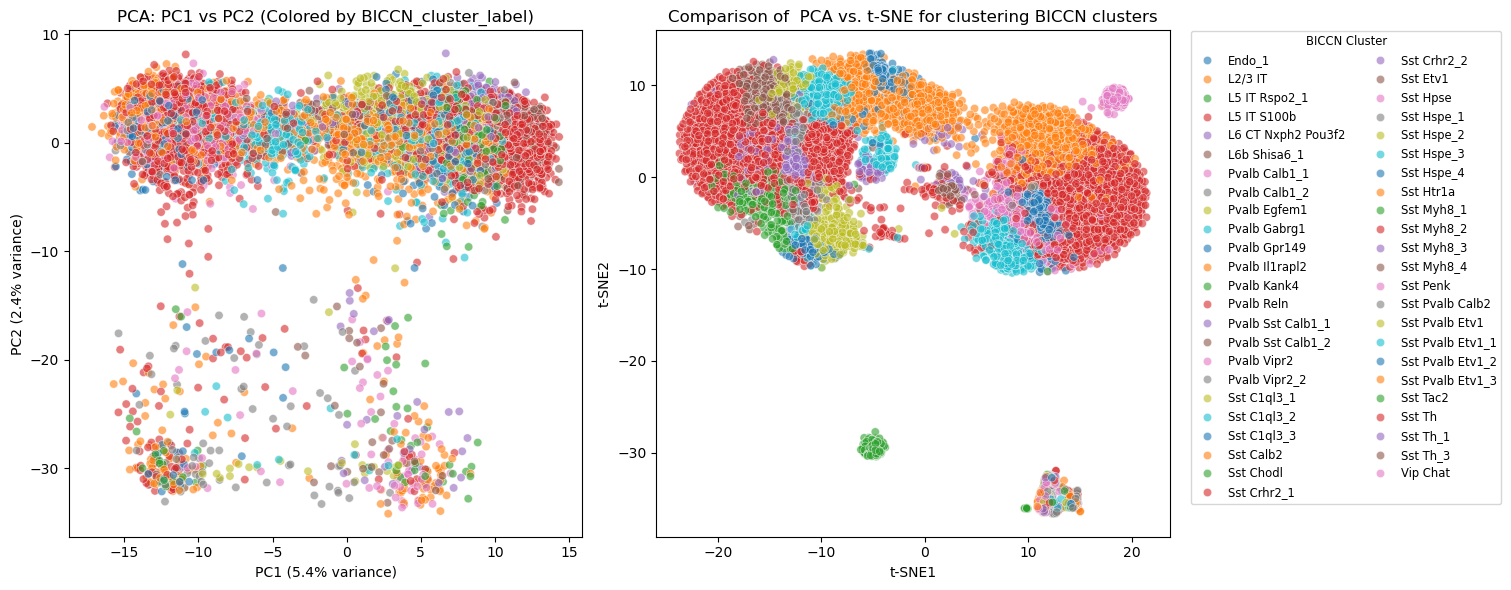

In [67]:
## Compare effectiveness of PCA vs. t-SNE for clustering BICCN clusters
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=False, sharey=False)

# PCA plot
scatter_pca = sns.scatterplot(ax=axes[0], x=df_pca[0], y=df_pca[1], 
                              hue=adata.obs.loc[df_pca.index, 'BICCN_cluster_label'], 
                              palette="tab10", alpha=0.6)
axes[0].set_xlabel(f"PC1 ({explained_variance[0]*100:.1f}% variance)")
axes[0].set_ylabel(f"PC2 ({explained_variance[1]*100:.1f}% variance)")
axes[0].set_title("PCA: PC1 vs PC2 (Colored by BICCN_cluster_label)")

# t-SNE plot
scatter_tsne = sns.scatterplot(ax=axes[1], x="tSNE1", y="tSNE2", 
                               hue=adata.obs.loc[df_pca.index, 'BICCN_cluster_label'], 
                               data=df_log, alpha=0.6, palette="tab10")
axes[1].set_xlabel("t-SNE1")
axes[1].set_ylabel("t-SNE2")
axes[1].set_title("t-SNE Visualization of Cells")

# Move legend outside the plot and make it shared
handles, labels = axes[0].get_legend_handles_labels()
legend = fig.legend(handles, labels, title="BICCN Cluster", bbox_to_anchor=(0.85, 0.95), 
                    loc="upper left", fontsize="small", title_fontsize="small", ncol=2)

# Remove individual legends from subplots
axes[0].legend_.remove()
axes[1].legend_.remove()

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space on the right for the legend
plt.show()